In [31]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import math
#import plotly
#import plotly.express.colors as color
%matplotlib inline

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data

In [7]:
dir = '/content/drive/MyDrive/projects/21_11_dacon_bicycle/'

bicycle = pd.read_csv(dir + '_data/train.csv')
t_bicycle = pd.read_csv(dir + '_data/test.csv')
bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


In [8]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []
    
    for date in dataframe.date_time :
        year_point, month_point, day_point = date.split('-')
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
        
    return year, month, day

for D in [bicycle, t_bicycle]:
    year, month, day = seperate_datetime(D)
    D['year'] = year
    D['month'] = month
    D['day'] = day
    D['weekday'] = pd.to_datetime(D['date_time']).dt.weekday
    D.drop('date_time', axis=1, inplace=True)
    D['weekend'] =  D['weekday'] > 5
    
bicycle.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,weekday,weekend
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,6,True
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,0,False
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,1,False
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,2,False
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,3,False


## 2.EDA

### 이동평균

In [9]:
fig,ax = plt.subplots(bicycle.shape[0]//7 + 1,7, figsize=(40,160))
for bin in range(bicycle.shape[0]):
  ma = []
  for i in range(bicycle.shape[0]-bin):  
    ma.append(np.mean(bicycle['number_of_rentals'][i:i+bin]))
  
  ax[bin//7][bin%7].plot(ma)

Output hidden; open in https://colab.research.google.com to view.

### 데이터 정리

가정 1. 주중 - 주말의 이용층이 다르다.   
주중 : 등하교 및 출퇴근 - 상대적으로 변수에 대해 덜 민감하고 평균기온즈음에 사용할것(9시 / 18시)
주말 : 여행 및 피크닉 - 상대적으로 변수에 더 민감하고 최고 기온 주변에서 사용할 것(12~17시)

가정 2. 따릉이 이용량은 꾸준히 증가해 왔고 앞으로도 그럴 것이다.

체감온도와 불쾌지수

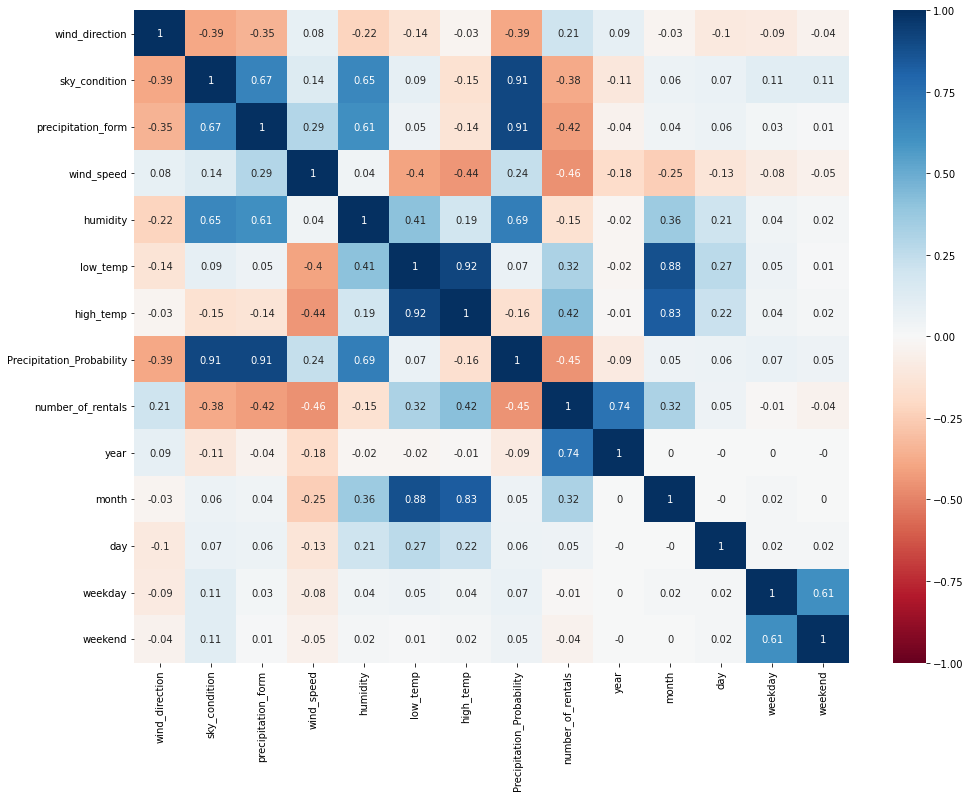

In [10]:
corr = np.round(bicycle.corr(),2)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(16,12))
hm = sns.heatmap(corr,
                 #mask=mask,
                 vmin=-1, 
                 vmax=1, 
                 annot=True,
                 cmap='RdBu'
    )

### 데이터 분포

- wind_direction: 풍향 (degree)
- sky_condition : 맑음(1), 구름많음(3), 흐림(4)
- precipitation_form : 강수 형태 / 없음(0), 비(1), 진눈깨비(2), 눈(3), 소나기(4)
- wind_speed : 풍속 (m/s)
- humidity : 습도 (%)
- low_temp : 최저 기온 ( `C)
- high_temp : 최고 기온 ( `C)
- Precipitation_Probability : 강수 확률 (%)
- number_of_rentals : 따릉이 대여량

### 데이터 편집

독립성이 부족하거나 의미가 없는 데이터들을 통합 및 폐합, 새로운 데이터 생성

- 온도 통합 (평균)
- 강수량, 구름 삭제 (강수확률만 이용, 강수량은 시간대에 따른 변수가 있고, 강수확률이 있는 경우 따릉이 이용을 꺼려하는 경향이 있을 것이라고 가정)
- 의미없는 데이터 삭제(일, 요일)
- 의미를 알기 어려운 데이터 삭제(풍향)
- 습도는 불쾌지수로 사용하고 습도 자체 데이터는 삭제
- 기온은 평균기온과 최고기온을 사용

In [11]:
bicycle_new = bicycle.copy()
t_bicycle_new = t_bicycle.copy()

for D in [bicycle_new, t_bicycle_new]:
    
    #온도 통합 (평균, 최고기온)
    D['temp'] = (D['high_temp'] + D['low_temp']) / 2
    D.drop(['low_temp'], axis=1, inplace=True)
    
    #체감온도 
    D['feeling_temp'] = 13.12+0.6215*D['temp']-\
                        11.37*D['wind_speed']**(0.16)\
                        +0.3965*D['temp']*D['wind_speed']**(0.16)
    
    #불쾌지수
    D['temp_hum_index'] = 1.8*D['temp'] - 0.55 *\
                          (1 - D['humidity'])*(1.8*D['temp']-26) + 32
    
    D.drop(['temp'], axis=1, inplace=True)
    
    #습도삭제
    D.drop(['humidity'], axis=1, inplace=True)

    
    #강수확률 vs 강수형태 vs 구름 / 강수확률 우선테스트
    D.drop(['precipitation_form', 'sky_condition'], axis=1, inplace=True)

    #의미없는 데이터 삭제(일, 요일)
    D.drop(['weekday', 'day'], axis=1, inplace=True)

    #의미를 알기 어려운 데이터 삭제(풍향)
    D.drop(['wind_direction'], axis=1, inplace=True)

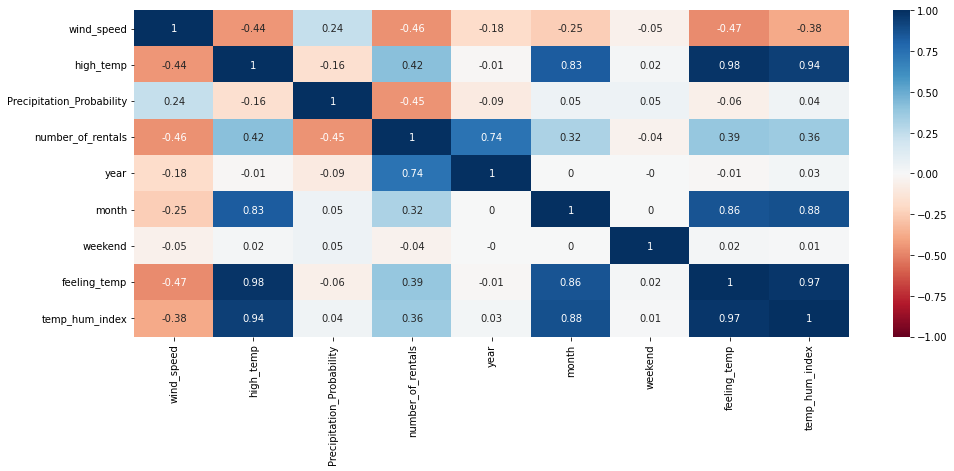

In [12]:
corr2 = np.round(bicycle_new.corr(),2)
mask = np.triu(np.ones_like(corr2, dtype=np.bool))
plt.figure(figsize=(16,6))
hm = sns.heatmap(corr2,
                 #mask=mask,
                 vmin=-1, 
                 vmax=1, 
                 annot=True,
                 cmap='RdBu'
    )

## 3. Model

### Fit

In [13]:
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

bicycle_feature = bicycle.drop('number_of_rentals', axis=1)

# bicycle_scaled = pd.DataFrame(scaler.fit_transform(bicycle_feature), columns=bicycle_feature.columns)
# t_bicycle_scaled = pd.DataFrame(scaler.transform(t_bicycle), columns=t_bicycle.columns)

In [14]:
#make_dataset by window

def make_dataset(X, y, window_size=5):
  X_list = []
  y_list = []
  for i in range(len(X) - window_size):
    X_list.append(np.array(X.iloc[i:i+window_size]))
    y_list.append(np.array(y[i:i+window_size]))

  return np.array(X_list), np.array(y_list)

In [51]:
from sklearn.model_selection import train_test_split

X = bicycle_scaled
y = bicycle['number_of_rentals']

X_, y_ = make_dataset(X, y, window_size=7)

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((212, 7, 13), (54, 7, 13))

In [52]:

pd.DataFrame(X_train[1])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.717139,0.000000,0.000,0.072518,0.430387,0.917198,0.903809,0.000000,0.5,1.0,0.800000,0.166667,0.0
1,0.362336,0.245333,0.047,0.020396,0.434602,0.935604,0.823259,0.106911,0.5,1.0,0.833333,0.333333,0.0
2,0.429961,0.878333,0.358,0.000000,0.707278,0.938647,0.812080,0.460529,0.5,1.0,0.866667,0.500000,0.0
3,0.581657,0.878333,0.000,0.155130,0.614450,0.917198,0.758395,0.322363,0.5,1.0,0.900000,0.666667,0.0
4,0.455549,1.000000,0.304,0.139473,0.685125,0.914106,0.762858,0.473686,0.5,1.0,0.933333,0.833333,0.0
5,0.691675,0.666667,0.108,0.262670,0.683548,0.883479,0.798648,0.256578,0.5,1.0,0.966667,1.000000,1.0
6,0.423143,0.000000,0.000,0.514421,0.158757,0.169922,0.294908,0.000000,1.0,0.0,0.000000,0.333333,0.0


In [53]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [54]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16,
               input_shape=(X_train.shape[1],
                            X_train.shape[2]),
               activation='relu',
               return_sequences=False))

model.add(Dense(1))

In [55]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'

filename = os.path.join(dir, model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, 
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')

history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=3,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
71/71 [==============================] - 3s 25ms/step - loss: 4310117888.0000 - val_loss: 4398731264.0000

Epoch 00001: val_loss improved from inf to 4398731264.00000, saving model to /content/drive/MyDrive/projects/21_11_dacon_bicycle/model/tmp_checkpoint.h5
Epoch 2/200
71/71 [==============================] - 2s 23ms/step - loss: 4088533248.0000 - val_loss: 3176206848.0000

Epoch 00002: val_loss improved from 4398731264.00000 to 3176206848.00000, saving model to /content/drive/MyDrive/projects/21_11_dacon_bicycle/model/tmp_checkpoint.h5
Epoch 3/200
71/71 [==============================] - 2s 24ms/step - loss: 1075212032.0000 - val_loss: 660848768.0000

Epoch 00003: val_loss improved from 3176206848.00000 to 660848768.00000, saving model to /content/drive/MyDrive/projects/21_11_dacon_bicycle/model/tmp_checkpoint.h5
Epoch 4/200
15/71 [=====>........................] - ETA: 1s - loss: 591616128.0000

KeyboardInterrupt: ignored

### Predict

In [21]:
model.load_weights(filename)
pred = model.predict(X_train)

pred.shape

(194, 1)

In [28]:
y_train

array([[ 22471,  26484,  65124, ...,  80735,  78504,  77190],
       [ 82600,  77149,  86541, ..., 101256,  80357,  92531],
       [ 54701,  83736,  60371, ...,  66405,  64111,  68414],
       ...,
       [ 42029,  43257,  45681, ...,  63256,  70213,  76439],
       [ 77056,  67346,  74994, ...,  78419,  82600,  77149],
       [ 55125,  57020,  28467, ...,  71707,  74960,  76110]])

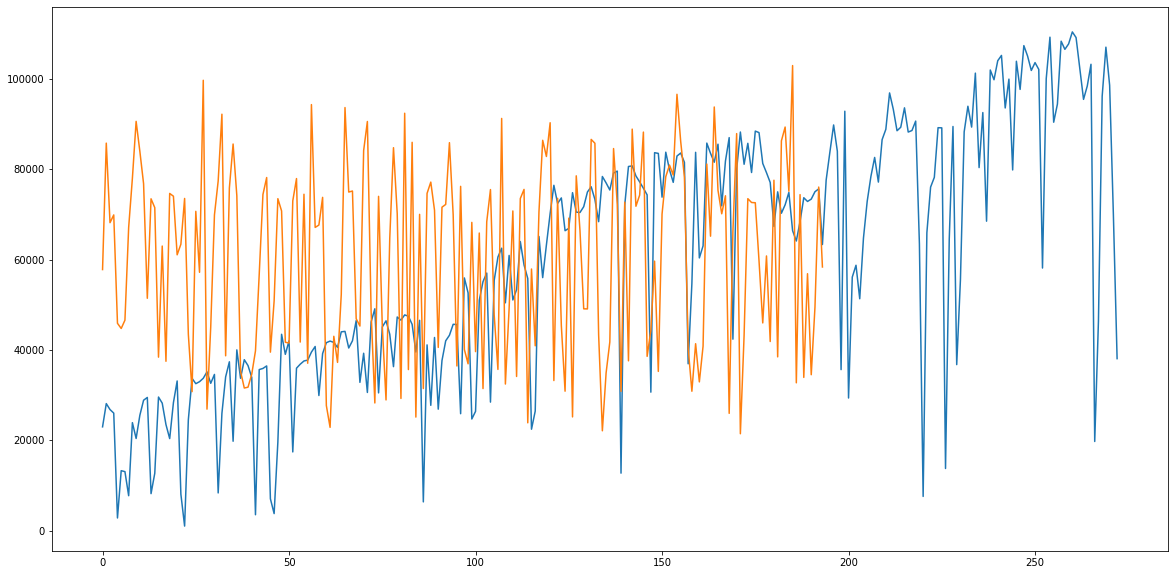

In [30]:
plt.figure(figsize=(20,10))
plt.plot(bicycle['number_of_rentals'])
plt.plot(pred)

### CV

In [ ]:
##### from sklearn.model_selection import cross_validate, cross_val_score
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm_notebook

# for n in range(1,10):
#     for m in range(50,1000,50):

params = []
mean_test_scores = []
mean_train_scores = []
#for l in tqdm_notebook(np.arange(0.01, 0.1, 0.01)):
#for n in tqdm_notebook(range(50,2000,50)):
n_split = 5

tscv = TimeSeriesSplit(n_splits=n_split)

test_scores = []
train_scores = []

model = XGBRegressor(booster='gbtree',
              n_estimators=150,
              learning_rate=0.02,
              max_depth=5,
              n_jobs=-1,
              random_state=0)

for train_index, test_index in tscv.split(X, y):
    train_X = X.iloc[train_index,:]
    test_X = X.iloc[test_index,:]
    train_y = y[train_index]
    test_y = y[test_index]

    model.fit(train_X, train_y)

    pred_test_y = model.predict(test_X)
    pred_train_y = model.predict(train_X)

    test_scores.append(NMAE(test_y, pred_test_y))
    train_scores.append(NMAE(train_y, pred_train_y))
    
# params.append(n)
# mean_test_scores.append(np.mean(test_scores))
# mean_train_scores.append(np.mean(train_scores))


    #print('maxdepth : ', n, ' / n_estimators : ', m, ' score : ', np.mean(scores))

    #     model.fit(X, y)
    #     y_hat = model.predict(X)
    #     nmae = NMAE(y, y_hat)
    #     print(f'모델 NMAE : {nmae}')

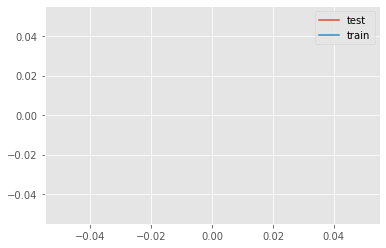

In [ ]:
plt.plot(params, mean_test_scores)
plt.plot(params, mean_train_scores)
plt.legend(['test', 'train'])
plt.show()

In [ ]:
model = XGBRegressor(booster='gbtree',
             n_estimators=150,
             learning_rate=0.02,
             max_depth=5,
             n_jobs=-1,
             random_state=0)

model.fit(X,y)
y_hat = model.predict(X)

## 4.Evaluate Model

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(np.concatenate([y_hat, result]), label='prediction')
plt.plot(y, label='real')
plt.legend(fontsize=20)
plt.show()

NameError: ignored

<Figure size 1440x720 with 0 Axes>

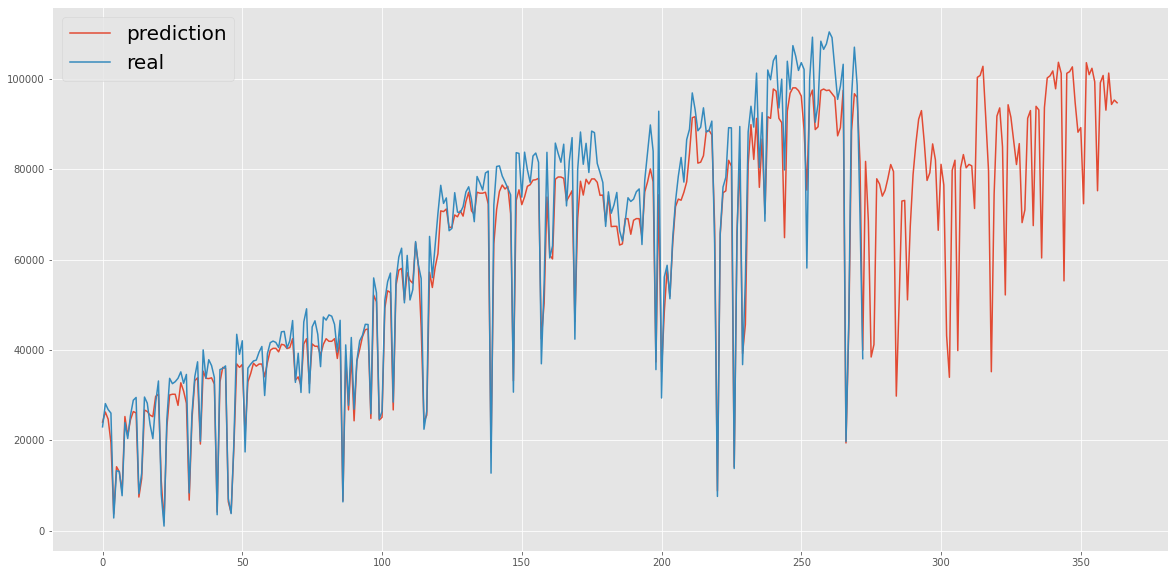

In [ ]:
rf = pd.read_csv(dir + '_result/4.RandomForrest.csv')

plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(np.concatenate([y_hat, list(rf['number_of_rentals'])]), label='prediction')
plt.plot(y, label='real')
plt.legend(fontsize=20)
plt.show()

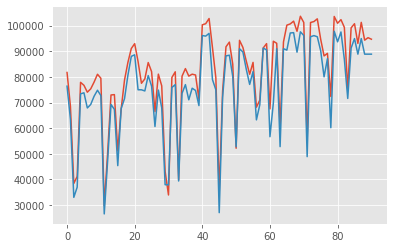

In [ ]:
plt.plot(list(rf['number_of_rentals']))
plt.plot(result)

## 5.Submission

In [ ]:
submission = pd.read_csv(dir + '_data/sample_submission.csv')

In [ ]:
result = model.predict(t_bicycle_new)

In [ ]:
submission['number_of_rentals'] = result

In [ ]:
#submission.to_csv('_result/7.xgboost.csv', index=False)